# Day 8: Resonant Collinearity

You find yourselves on the roof of a top-secret Easter Bunny installation.

While The Historians do their thing, you take a look at the familiar huge antenna. Much to your surprise, it seems to have been reconfigured to emit a signal that makes people 0.1% more likely to buy Easter Bunny brand Imitation Mediocre Chocolate as a Christmas gift! **Unthinkable!**

Scanning across the city, you find that there are actually many such antennas. Each antenna is tuned to a specific frequency indicated by a single **lowercase letter**, **uppercase letter**, or **digit**. You create a map (your puzzle input) of these antennas. For example:

```
............
........0...
.....0......
.......0....
....0.......
......A.....
............
............
........A...
.........A..
............
............
```

The signal only applies its nefarious effect at specific **antinodes** based on the **resonant frequencies** of the antennas. In particular, an antinode occurs at any point that is **perfectly in line** with two antennas of the same frequency — but only when **one of the antennas is twice as far away** as the other. This means that for any pair of antennas with the same frequency, there are two antinodes, one on either side of them.

For these two antennas with frequency `a`, they create the two antinodes marked with `#`:

```
..........
...#......
..........
....a.....
..........
.....a....
..........
......#...
..........
..........
```

Adding a third antenna with the same frequency creates several more antinodes. Ideally, it would add four antinodes, but two are off the right side of the map, so instead it adds only two:

```
..........
...#......
#.........
....a.....
........a.
.....a....
..#.......
......#...
..........
..........
```

Antennas with **different frequencies** don't create antinodes; `A` and `a` count as **different frequencies**. However, antinodes can occur at locations that **contain antennas**. In this diagram, the lone antenna with frequency capital `A` creates no antinodes but has a lowercase-`a`-frequency antinode at its location:

```
..........
...#......
#.........
....a.....
........a.
.....a....
..#.......
......A...
..........
..........
```

The first example has antennas with two different frequencies, so the antinodes they create look like this, plus an antinode overlapping the topmost `A`-frequency antenna:

```
......#....#
...#....0...
....#0....#.
..#....0....
....0....#..
.#....A.....
...#........
#......#....
........A...
.........A..
..........#.
..........#.
```

Because the topmost `A`-frequency antenna overlaps with a `0`-frequency antinode, there are **14 total unique locations** that contain an antinode within the bounds of the map.

---

### Puzzle

**Calculate the impact of the signal. How many unique locations within the bounds of the map contain an antinode?**

np.count_nonzero(map.antinodes_grid)=14


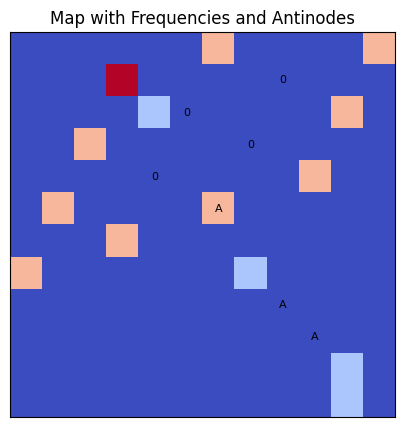

In [1]:
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt


@dataclass
class Map:
    grid: np.ndarray
    antinodes_grid: np.ndarray = field(init=False)
    frequencies: set = field(init=False)

    def __post_init__(self):
        self.antinodes_grid = np.zeros_like(self.grid, dtype=int)
        self.frequencies = set(np.unique(self.grid)) - {"."}

    @classmethod
    def from_file(cls, filepath: str) -> "Map":
        with open(filepath, "r", encoding="utf-8") as f:
            grid = np.array([list(line.strip()) for line in f])
        return cls(grid=grid)

    def compute_antinodes(self, resonant: bool = False):
        nth_harmonic = max(self.grid.shape) if resonant else 1
        harmonics = self.get_harmonics(n=nth_harmonic, mirrored=nth_harmonic != 1)

        for frequency in self.frequencies:
            antennas = np.argwhere(self.grid == frequency)  # (N, 2)
            antinodes = self.get_antinodes(antennas, harmonics)
            antinodes = self.filter_out_of_bounds(antinodes, self.grid.shape)
            self.update_antinodes_grid(antinodes, frequency)
            yield frequency

    @staticmethod
    def get_antinodes(antennas: np.ndarray, harmonics: np.ndarray):
        # compute pairwise deltas between all antennas, shape=(N, N, 2)
        deltas = antennas[:, None, :] - antennas[None, :, :]

        # exclude self-pairs (diagonal elements), shape=(N, N-1, 2)
        deltas = deltas[np.eye(len(antennas)) == 0].reshape(len(antennas), -1, 2)

        # scale deltas by harmonic factors, shape=(N, N-1, K, 2)
        deltas = deltas[:, :, None, :] * harmonics[None, None, :, None]

        # compute antinodes by adding scaled deltas, shape=(N, N-1, K, 2)
        antinodes = antennas[:, None, None, :] + deltas

        # reshape to a flat array of antinode positions, shape=(N * (N-1) * K, 2)
        return antinodes.reshape(-1, 2)

    @staticmethod
    def get_harmonics(n: int, mirrored: bool = True) -> np.ndarray:
        harmonics = np.arange(1, n + 1)
        if mirrored:
            harmonics = np.concatenate((harmonics, -harmonics[::-1]))
        return harmonics

    @staticmethod
    def filter_out_of_bounds(antinodes: np.ndarray, grid_shape: tuple) -> np.ndarray:
        # Reshape and filter out-of-bounds positions
        mask = (np.array([[0, 0]]) <= antinodes) & (antinodes < grid_shape)
        return antinodes[np.all(mask, axis=1)]  # row-wise boolean mask

    def update_antinodes_grid(self, antinodes: np.ndarray, frequency: str):
        # transposes to (2, N) and unpack in two different arrays for indexing
        x, y = antinodes.T
        self.antinodes_grid[x, y] += list(self.frequencies).index(frequency) + 1

    def reset_antinodes_grid(self):
        self.antinodes_grid = np.zeros_like(self.antinodes_grid)

    def render(self, figsize: tuple[int] = (8, 8)):
        _, ax = plt.subplots(figsize=figsize)
        cmap = plt.colormaps.get_cmap("coolwarm")

        # Plot color grid
        ax.imshow(self.antinodes_grid, cmap=cmap, interpolation="nearest", alpha=1)

        # Overlay frequencies
        for (i, j), char in np.ndenumerate(self.grid):
            if char != ".":
                ax.text(j, i, char, ha="center", va="center", color="black", fontsize=8)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(visible=False)  # , which="both", color="gray", linewidth=0.5)

        plt.title("Map with Frequencies and Antinodes")
        plt.show()


map = Map.from_file("./example.txt")
for frequency in map.compute_antinodes():
    continue
print(f"{np.count_nonzero(map.antinodes_grid)=}")
map.render(figsize=(5, 5))

np.count_nonzero(map.antinodes_grid)=247


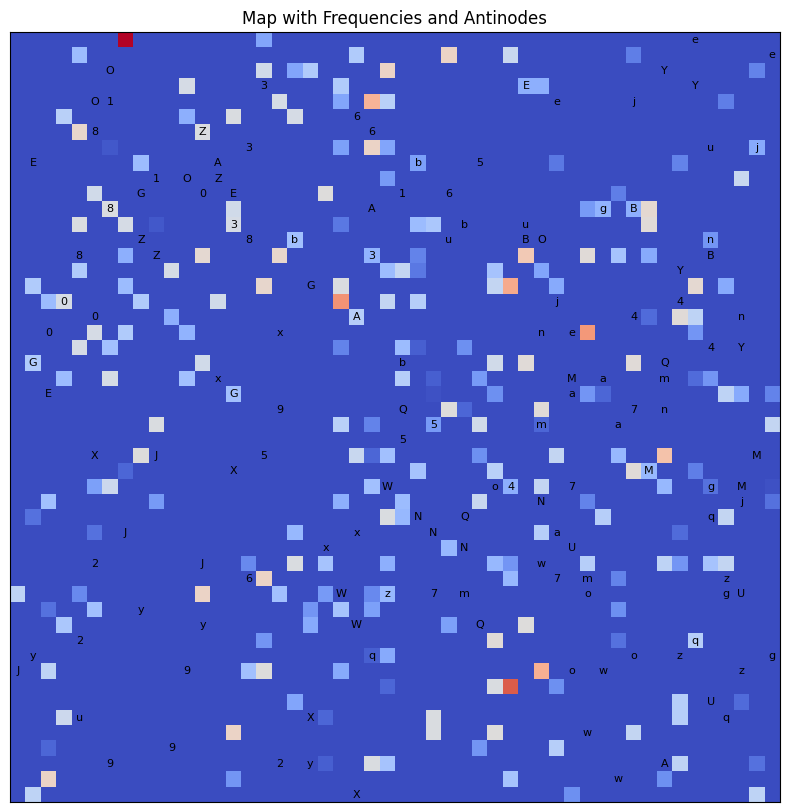

In [2]:
map = Map.from_file("./input.txt")
for frequency in map.compute_antinodes():
    continue
print(f"{np.count_nonzero(map.antinodes_grid)=}")
map.render(figsize=(10, 10))

# Part Two

Watching over your shoulder as you work, one of The Historians asks if you took the effects of **resonant harmonics** into your calculations.

Whoops!

After updating your model, it turns out that an **antinode** occurs at any grid position exactly in line with at least two antennas of the same frequency, regardless of distance. This means that some of the new antinodes will occur at the position of each antenna (unless that antenna is the only one of its frequency).

So, these three T-frequency antennas now create many antinodes:

```
T....#....
...T......
.T....#...
.........#
..#.......
..........
...#......
..........
....#.....
..........
```

In fact, the three T-frequency antennas are all exactly in line with two antennas, so they are all also antinodes! This brings the total number of antinodes in the above example to **9**.

The original example now has **34 antinodes**, including the antinodes that appear on every antenna:

```
##....#....#
.#.#....0...
..#.#0....#.
..##...0....
....0....#..
.#...#A....#
...#..#.....
#....#.#....
..#.....A...
....#....A..
.#........#.
...#......##
```

---

## Task

Calculate the impact of the signal using this updated model. **How many unique locations within the bounds of the map contain an antinode?**

np.count_nonzero(map.antinodes_grid)=34


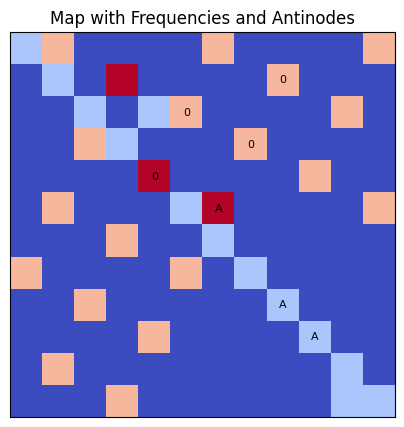

In [3]:
map = Map.from_file("./example.txt")
for frequency in map.compute_antinodes(resonant=True):
    continue
print(f"{np.count_nonzero(map.antinodes_grid)=}")
map.render(figsize=(5, 5))

np.count_nonzero(map.antinodes_grid)=861


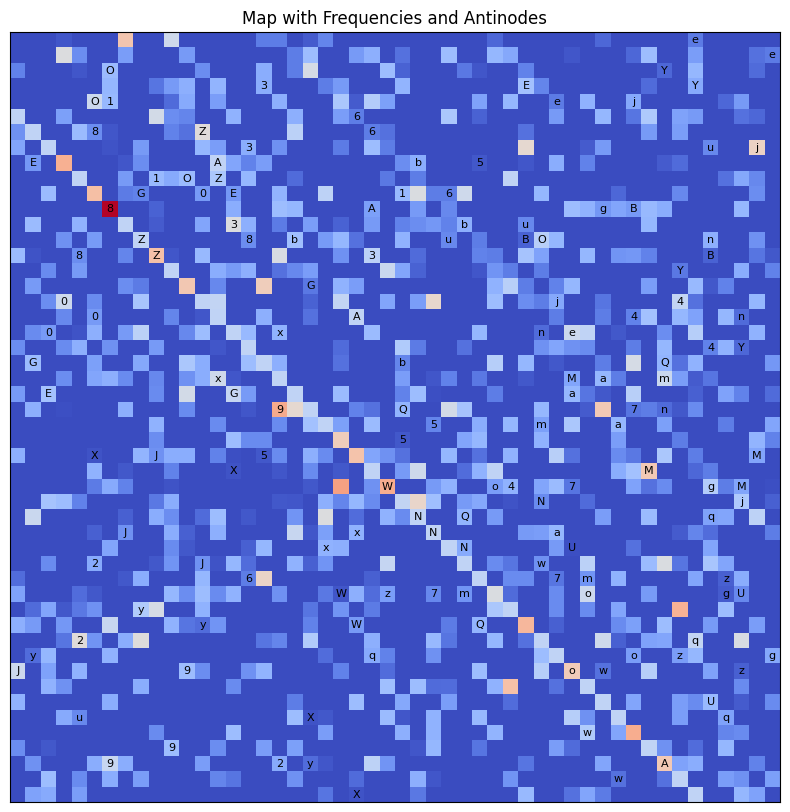

In [4]:
map = Map.from_file("./input.txt")
for frequency in map.compute_antinodes(resonant=True):
    continue
print(f"{np.count_nonzero(map.antinodes_grid)=}")
map.render(figsize=(10, 10))

## Animation

In [9]:
import io
import imageio
from tqdm.auto import tqdm
import plotly.graph_objects as go
import plotly.io as pio


class AnimatedMap(Map):
    def render_animation(
        self, resonant=True, html_file="animated_map.html", gif_file="animation.gif"
    ):
        self.reset_antinodes_grid()
        for frequency in self.compute_antinodes(resonant):
            continue
        ref_grid = np.log(self.antinodes_grid.copy() + 1)
        self.reset_antinodes_grid()

        cmap = "Electric"  # Better color scale for contrast

        # Initialize the figure
        fig = self._initialize_figure(cmap, ref_grid)

        # Generate and add animation frames
        fig.frames = self._generate_frames(cmap, resonant)

        # Configure layout
        self._configure_layout(fig)

        # Export to HTML
        # self._export_to_html(fig, html_file)

        # Create GIF directly from frames
        self._create_gif(fig, gif_file)

    def _initialize_figure(self, cmap, ref_grid: np.ndarray):
        """Initialize the figure with an empty heatmap."""
        return go.Figure(
            data=go.Heatmap(
                z=self.antinodes_grid,
                colorscale=cmap,
                zmin=ref_grid.min(),
                zmax=ref_grid.max(),
                showscale=False,  # No colorbar
            )
        )

    def _generate_frames(self, cmap, resonant):
        """Generate animation frames with updated annotations."""
        frames = []
        prev_antinodes_grid = self.antinodes_grid.copy()
        for i, frequency in enumerate(self.compute_antinodes(resonant)):
            annotations = self._generate_annotations(list(self.frequencies)[: i + 1])

            # show any past frequencies before current antinodes
            frames.append(
                go.Frame(
                    data=[
                        go.Heatmap(
                            z=np.log(prev_antinodes_grid + 1) * 0.6,
                            colorscale=cmap,
                            showscale=False,  # No colorbar
                        )
                    ],
                    layout=go.Layout(annotations=annotations),
                    name=f"Freq {frequency}",
                )
            )
            prev_antinodes_grid = self.antinodes_grid.copy()

            # show any past frequencies with current antinodes
            frames.append(
                go.Frame(
                    data=[
                        go.Heatmap(
                            z=np.log(self.antinodes_grid + 1) * 0.6,
                            colorscale=cmap,
                            showscale=False,  # No colorbar
                        )
                    ],
                    layout=go.Layout(annotations=annotations),
                    name=f"Freq {frequency}",
                )
            )

        return frames

    def _generate_annotations(self, frequencies: list[str]):
        """Create annotations for the grid with dynamic text colors."""
        # Find indices where the grid elements match frequencies
        rows, cols = np.where(np.isin(self.grid, frequencies))

        # Create annotations only for the matching cells
        annotations = [
            dict(
                x=col,
                y=row,
                text=self.grid[row, col],
                showarrow=False,
                font=dict(
                    color="white",
                    size=8,
                ),
                align="center",
            )
            for row, col in zip(rows, cols)
        ]

        return annotations

    def _configure_layout(self, fig):
        """Configure layout for improved aesthetics."""
        fig.update_layout(
            xaxis=dict(
                visible=False, scaleanchor="y", scaleratio=1
            ),  # Square aspect ratio
            yaxis=dict(visible=False),
            margin=dict(l=1, r=1, t=1, b=1),  # Minimal margins
            updatemenus=[],  # Remove play/pause buttons
        )
        fig.update(frames=fig.frames)  # Link frames

    def _export_to_html(self, fig, output_file):
        """Export the animation to an HTML file."""
        fig.write_html(
            output_file,
            auto_play=True,  # Automatically start playing animation
            include_plotlyjs="cdn",  # Include Plotly JS via CDN for portability
        )
        print(f"Animation exported to {output_file}")

    def _create_gif(self, fig, gif_file):
        """Create a GIF directly from animation frames, including annotations."""
        images = []
        for frame in tqdm(fig.frames):
            # Update the figure with the current frame's data and annotations
            fig.update(data=frame.data)
            fig.update_layout(annotations=frame.layout.annotations)

            # Render the current frame to an image in memory
            images.append(
                imageio.v3.imread(
                    io.BytesIO(
                        pio.to_image(
                            fig, format="png", engine="kaleido", width=500, height=500
                        )
                    )
                )
            )

        # Save the GIF
        imageio.mimsave(gif_file, images, fps=6)
        print(f"GIF saved to {gif_file}")

    @classmethod
    def from_file(cls, filepath: str) -> "AnimatedMap":
        return super().from_file(filepath)


# Example usage
#anim_map = AnimatedMap.from_file("./input.txt")
#anim_map.render_animation()

  0%|          | 0/76 [00:00<?, ?it/s]

GIF saved to animation.gif
